# Plot HRRR data on top of GOES16

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import sys
from datetime import datetime, timedelta

import sys
sys.path.append('/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v2')
from BB_downloads.HRRR_S3 import get_hrrr_variable
from BB_GOES16.get_GOES16 import *
from BB_GOES16.match_GLM_to_ABI import accumulate_GLM_flashes_for_ABI
from BB_basemap.draw_maps import draw_CONUS_HRRR_map

In [2]:
VALIDDATE = datetime(2018, 6, 3, 23)

fxx = 0
RUNDATE = VALIDDATE - timedelta(hours=fxx)

In [3]:
# Get HRRR data
H_500 = get_hrrr_variable(RUNDATE, 'HGT:500 mb', fxx=fxx, verbose=False)
H_REFC = get_hrrr_variable(RUNDATE, 'REFC:entire', fxx=fxx, verbose=False)
H_LTNG = get_hrrr_variable(RUNDATE, 'LTNG:entire', fxx=fxx, verbose=False)
H_UV = get_hrrr_variable(RUNDATE, 'UVGRD:10 m', fxx=fxx, verbose=False)

In [4]:
# Get GOES-16 Data
ABI = get_GOES16_truecolor(file_nearest(VALIDDATE))
GLM = accumulate_GLM_flashes_for_ABI(file_nearest(VALIDDATE))

Fetching: /uufs/chpc.utah.edu/common/home/horel-group7/Pando/GOES16/ABI-L2-MCMIPC/20180603/OR_ABI-L2-MCMIPC-M3_G16_s20181542302296_e20181542305069_c20181542305189.nc


/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v2/BB_GOES16/get_GOES16.py:79: RuntimeWarning: invalid value encountered in power
  R = np.power(C.variables['CMI_C02'][:], gamma) # Band 2 is red (0.64 um)
/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v2/BB_GOES16/get_GOES16.py:80: RuntimeWarning: invalid value encountered in power
  G = np.power(C.variables['CMI_C03'][:], gamma) # Band 3 is "green" (0.865 um)
/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v2/BB_GOES16/get_GOES16.py:81: RuntimeWarning: invalid value encountered in power
  B = np.power(C.variables['CMI_C01'][:], gamma) # Band 1 is blue (0.47 um)



   Gamma correction: 0.4
   Contrast correction: 150



In [5]:
m = draw_CONUS_HRRR_map()

In [6]:
dBZ = H_REFC['value']
dBZ = np.ma.array(dBZ)
dBZ[dBZ < 10] = np.ma.masked

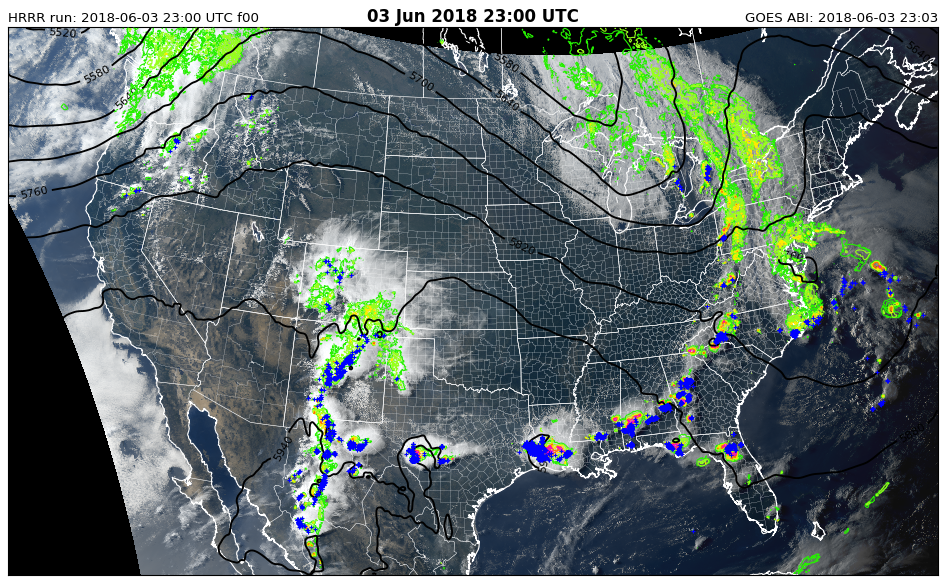

In [7]:
plt.figure(figsize=[15, 10])

# Plot GOES True Color
newmap = m.pcolormesh(ABI['lon'], ABI['lat'], ABI['TrueColor'][:,:,1],
             color=ABI['rgb_tuple'],
             linewidth=0,
             zorder=1,
             latlon=True)
newmap.set_array(None)

# Plot HRRR Radar
m.contour(H_REFC['lon'], H_REFC['lat'], dBZ,
          cmap='gist_ncar',
          levels=range(20, 81, 10),
          vmin=-10, vmax=80,
          zorder=5,
          latlon=True)

# Plot HRRR 500 hPa
CS = m.contour(H_REFC['lon'], H_REFC['lat'], H_500['value'],
               levels=range(3000, 8000, 60),
               linewidths=1.7,
               colors='k', 
               zorder=5,
               latlon=True)
plt.clabel(CS, inline=1, fmt='%2.f',zorder=50)

# Plot GOES GLM
m.scatter(GLM['longitude'], GLM['latitude'], marker='+', color='blue', latlon=True, zorder=10)

m.drawmapboundary(fill_color='k')
m.drawcoastlines(color='w')
m.drawcountries(color='w')
m.drawcounties(color='w')
m.drawstates(color='w')

plt.title(H_500['valid'].strftime('%d %b %Y %H:%M UTC'), fontsize=15, fontweight='semibold')
plt.title('HRRR run: %s f%02d' % (H_500['anlys'].strftime('%Y-%m-%d %H:%M UTC'), fxx), loc='left')
plt.title('GOES ABI: %s' % ABI['DATE'].strftime('%Y-%m-%d %H:%M'), loc='right')